# Project 2: Clinical Data Remediation and Bias Reduction Pipeline
---
Goals:
- Develop an automated, reproducible Python-based pipeline to audit, remediate, and validate the quality of a large-scale clinical dataset.
- Improve the overall Data Quality Index (DQI) by addressing systemic issues in Completeness, Validity, and Consistency commonly found in electronic health records.
- Reduce statistical bias introduced by missing clinical data while preserving the integrity of medically meaningful distributions.
- Demonstrate how improved data quality directly enhances downstream predictive modeling performance for hospital readmission risk.

## Setup & Environment
---

Summary:

- Imports:
    - os,sys
    - warnings
    - pandas (pd) & numpy (np)
    - DataAuditor & DataRemediator
    - StandardScaler, ColumnTransformer, OneHotEncoder, compute_class_weight
    - train_test_split, Logistic Regression, RandomForestClassifier
    - Evaluation metrics (roc_auc_score, confusion_matrix, etc,)
    - XGBClassifier
    - Visualization libraries (plt, sns)
      
- Load/ Setup Process:
    - Clone repo
    - Move into project folder
    - Verify files exist

In [5]:
#Core libraries
import os
import sys
import warnings
warnings.filterwarnings("ignore")

#Data handling
import pandas as pd
import numpy as np

#Specific imports
from DataAuditor import DataAuditor
from remediator import DataRemediator
from sklearn.preprocessing import StandardScaler

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Clone repo (only if it doesn't already exist)
if not os.path.exists("Diabetes_Clinical_Remediation_Pipeline"):
    !git clone https://github.com/pandakitty/Diabetes_Clinical_Remediation_Pipeline.git
else:
    print("Repository already exists — skipping clone.")

Repository already exists — skipping clone.


In [3]:
#Move into the cloned project directory and verify contents
#Change working directory to the cloned repo
if not os.getcwd().endswith('Diabetes_Clinical_Remediation_Pipeline'):
    os.chdir('Diabetes_Clinical_Remediation_Pipeline')

#Verify the contents of the repo
os.listdir()

['.git',
 '.github',
 '.gitignore',
 'data',
 'Diabetes_Clinical_Remediation_Pipeline',
 'documentation',
 'index.md',
 'LICENSE',
 'main.py',
 'notebooks',
 'plots',
 'README.md',
 'references.md',
 'reports',
 'requirements.txt',
 'src',
 '_config.yml']

## Data Processing
---
Summary:
- Process:
    - Initialize the `DataRemediator`
    - Statistical Remediation (MICE/KNN)
        - Numeric features imputed
        - Identifier columns (`encounter_id`, `patient_nbr`) were excluded to avoid artificial changes
        - Columns with extreme missingness (e.g., `weight`) were preserved to prevent introducing bias
    - Semantic Consistency (ICD-9 Codes)
        - Primary, secondary, and tertiary diagnosis codes (`diag_1`, `diag_2`, `diag_3`) were standardized using regex-based normalization
        - Numeric and categorical data recombined to produce the final remediated dataset
- Output:
    - `final_df` contains:
        - Fully imputed numeric clinical variables (except those intentionally preserved like `weight`)
        - Normalized ICD-9 codes
        - Preserved categorical features
        - Consistent identifiers
        - Optional binary target `readmit_30days` for <30 day readmissions

In [6]:
#Run the full data audit to generate cleaned_df

#Add src folder to Python path
sys.path.append(os.path.abspath('src'))

#Import the DataAuditor class
from DataAuditor import DataAuditor

#Initialize auditor with the raw dataset
auditor = DataAuditor(path='data/diabetic_data.csv')

#Run the full audit
audit_results = auditor.run_full_audit(verbose=True)

#Extract the cleaned df
cleaned_df = audit_results['cleaned_data']

#Preview
cleaned_df.head()

Removed 0 duplicate rows
Rows (cleaned): 101766
Unique patients: 71518
Baseline DQI: 0.982

DQI Components: {'completeness': 0.945, 'coded_consistency': 1.0, 'duplicates': np.float64(1.0)}


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,0-10,nan,6,25,1,1,...,No,No,No,No,No,No,NO,NaN,NaN,Physician Referral
1,149190,55629189,Caucasian,Female,10-20,nan,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,20-30,nan,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,30-40,nan,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,40-50,nan,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [7]:
#Keep a safe copy of target
target_column = cleaned_df['readmitted'].copy()

In [8]:
#Apply remediator fixes
#- MICE/KNN imputation (on numeric clinical features)
#- ICD-9 normalization using regex rules

#Initialize the remediator
remediator = DataRemediator()

#Identifier columns (must NEVER be imputed)
id_cols = ['encounter_id', 'patient_nbr']

#Separate numeric columns (EXCLUDING identifiers)
numeric_cols = [
    col for col in cleaned_df.select_dtypes(include=[np.number]).columns
    if col not in id_cols
]

#Scale numeric features
scaler = StandardScaler()
scaled_numeric = pd.DataFrame(
    scaler.fit_transform(cleaned_df[numeric_cols]),
    columns=numeric_cols,
    index=cleaned_df.index
)

#Apply MICE/KNN imputation on scaled data
imputed_scaled_numeric = remediator.apply_mice_imputation(scaled_numeric)

#Inverse scale back to original units
imputed_numeric_df = pd.DataFrame(
    scaler.inverse_transform(imputed_scaled_numeric),
    columns=numeric_cols,
    index=cleaned_df.index
)

#Recombine imputed numeric data with untouched categorical data
imputed_df = cleaned_df.copy()
imputed_df[numeric_cols] = imputed_numeric_df

#Normalize ICD-9 diagnosis codes using regex rules
icd9_columns = ['diag_1', 'diag_2', 'diag_3']

final_df = imputed_df.copy()
for col in icd9_columns:
    final_df = remediator.normalize_icd9(final_df, col)

#Preview the final remediated DataFrame
final_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,0-10,nan,6.0,25.0,1.0,1.0,...,No,No,No,No,No,No,NO,NaN,NaN,Physician Referral
1,149190,55629189,Caucasian,Female,10-20,nan,1.0,1.0,7.0,3.0,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,20-30,nan,1.0,1.0,7.0,2.0,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,30-40,nan,1.0,1.0,7.0,2.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,40-50,nan,1.0,1.0,7.0,1.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [9]:
#Map 'readmitted' to numeric for modeling

#Restore the target column from the original cleaned_df
final_df['readmitted'] = target_column

#Map all variants to numeric (0 = NO, 1 = YES / >30 / <30)
final_df['readmitted'] = final_df['readmitted'].map({
    'NO': 0,
    'YES': 1,
    '>30': 1,
    '<30': 1
})

#Create a separate binary target for <30 day readmission
final_df['readmit_30days'] = (final_df['readmitted'] == 1).astype(int)

#Quick sanity check
print("Remaining NaNs in target:", final_df['readmitted'].isna().sum())
print("Value counts:\n", final_df['readmitted'].value_counts())

Remaining NaNs in target: 0
Value counts:
 readmitted
0    54864
1    46902
Name: count, dtype: int64


## Remediation Validation
---
Summary:
- Process:
    - Compare key numeric features before and after MICE/KNN imputation
        - Feature checked: `num_medications`, `num_lab_procedures`,`number_inpatient`, `number_outpatient`, `number_emergency`, `number_diagnoses`
        - Likewise Detection stats were computed as baseline
        - MICE/KNN Imputed stats were computed to assess changes
    - Check remaining missing values in numeric & ICD-9 columns
    - Confirmed that imputation filled numeric gaps while preserving identifier columns
    - Columns with extreme missingness (e.g., `weight`, `payer_code`, `medical_specialty`) were left untouched to avoid introducing bias
- Output:
    - Means and medians of numeric features did not materially change after imputation
        - Example: `num_medications` -> mean: 16.02, median: 15.00 (unchanged)
        - Example: `number_inpatient` -> mean: 0.64, median: 0.00 (unchanged)
    - `final_df` validated and ready for modeling
        - Numeric distributions consistent with pre-imputation values

In [10]:
#Verify numeric features look reasonable
final_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,readmit_30days
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.460881,0.460881
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.498470,0.498470
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000,1.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000,1.000000


In [11]:
#Identify numeric columns (excluding identifiers)
id_cols = ['encounter_id', 'patient_nbr']
numeric_cols = [
    col for col in final_df.select_dtypes(include=['int64', 'float64']).columns
    if col not in id_cols
]

#Check types and missing values
print("Numeric feature types and missing values:")
print(final_df[numeric_cols].dtypes)
print(final_df[numeric_cols].isna().sum())

Numeric feature types and missing values:
admission_type_id           float64
discharge_disposition_id    float64
admission_source_id         float64
time_in_hospital            float64
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
number_diagnoses            float64
readmitted                    int64
readmit_30days                int64
dtype: object
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
readmitted                  0
readmit_30days              0
dtype: int64


In [12]:
#Identify categorical columns
cat_cols = final_df.select_dtypes(include=['object', 'category']).columns.tolist()

#Remove the target column(s)
cat_cols = [col for col in cat_cols if col not in ['readmitted', 'readmit_30days']]

print("Categorical columns:", cat_cols)
print("Sample unique values for each categorical column:")
for col in cat_cols[:10]:  # show first 10 for brevity
    print(f"{col}: {final_df[col].nunique()} unique values")

Categorical columns: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
Sample unique values for each categorical column:
race: 5 unique values
gender: 2 unique values
age: 10 unique values
weight: 10 unique values
payer_code: 17 unique values
medical_specialty: 72 unique values
diag_1: 711 unique values
diag_2: 708 unique values
diag_3: 731 unique values
max_glu_serum: 3 unique values


Feature: num_medications
  Listwise Deletion -> mean: 16.02, median: 15.00
  MICE/KNN Imputed -> mean: 16.02, median: 15.00
------------------------------------------------------------


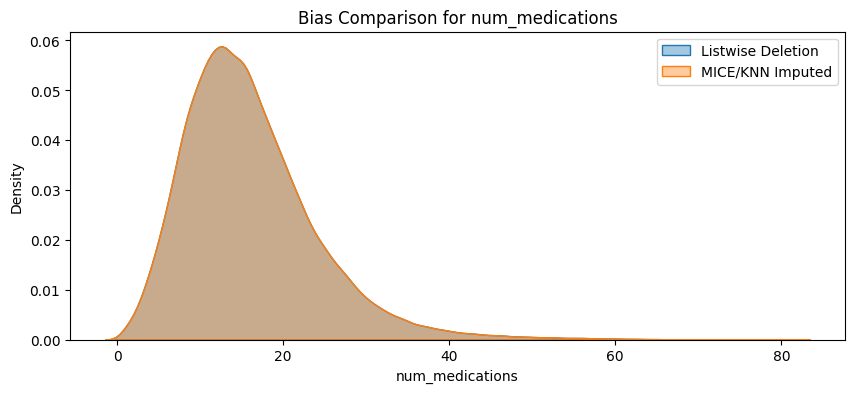

Feature: num_lab_procedures
  Listwise Deletion -> mean: 43.10, median: 44.00
  MICE/KNN Imputed -> mean: 43.10, median: 44.00
------------------------------------------------------------


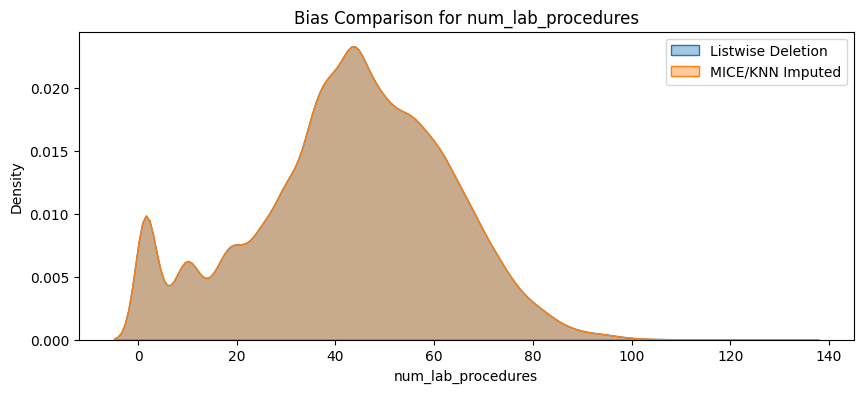

Feature: number_inpatient
  Listwise Deletion -> mean: 0.64, median: 0.00
  MICE/KNN Imputed -> mean: 0.64, median: 0.00
------------------------------------------------------------


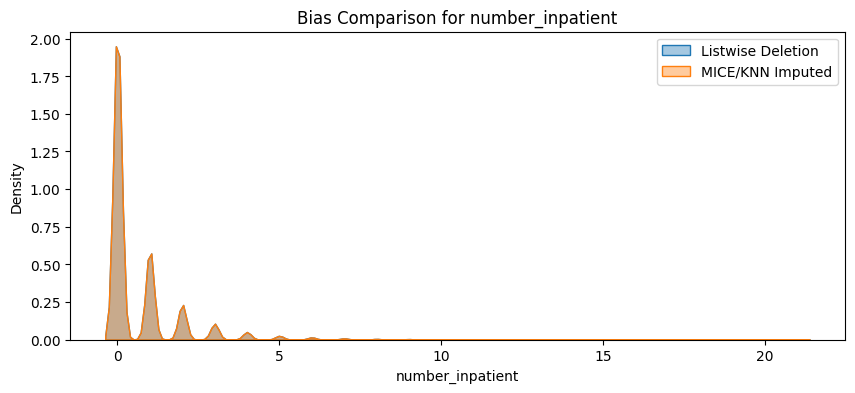

Feature: number_outpatient
  Listwise Deletion -> mean: 0.37, median: 0.00
  MICE/KNN Imputed -> mean: 0.37, median: 0.00
------------------------------------------------------------


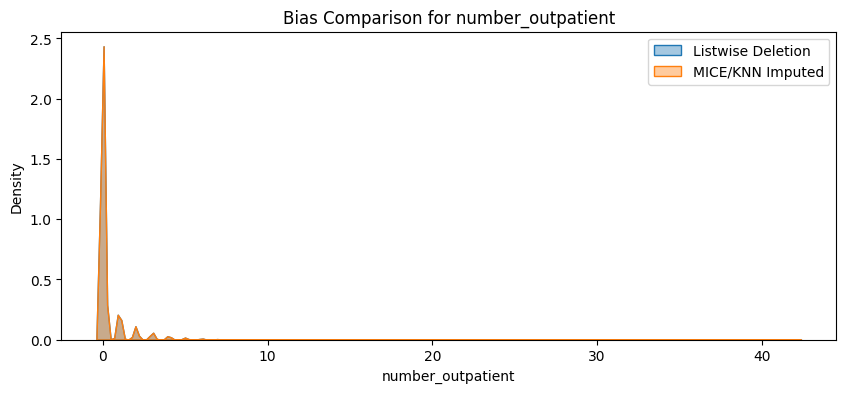

Feature: number_emergency
  Listwise Deletion -> mean: 0.20, median: 0.00
  MICE/KNN Imputed -> mean: 0.20, median: 0.00
------------------------------------------------------------


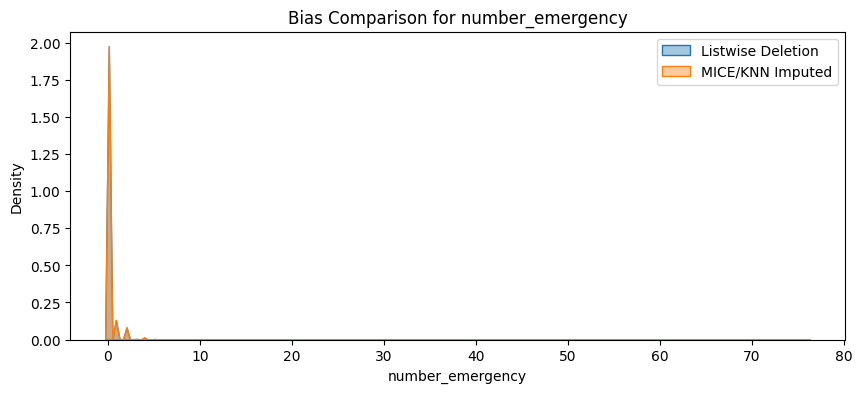

Feature: number_diagnoses
  Listwise Deletion -> mean: 7.42, median: 8.00
  MICE/KNN Imputed -> mean: 7.42, median: 8.00
------------------------------------------------------------


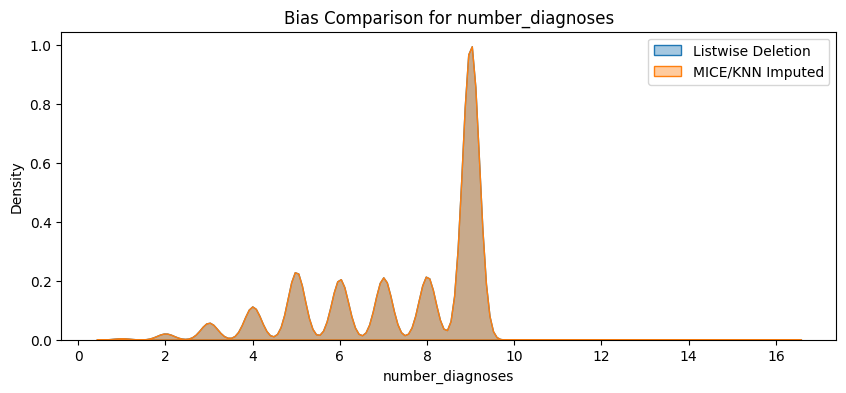

In [13]:
#Key numeric clinical features to validate
numeric_features = [
    'num_medications', 
    'num_lab_procedures', 
    'number_inpatient', 
    'number_outpatient', 
    'number_emergency', 
    'number_diagnoses'
]

#Loop through each feature for bias comparison
for feature in numeric_features:
    
#Drop rows with missing values for this feature
    baseline_df = cleaned_df.dropna(subset=[feature])
    
#Imputed: Final remediated DataFrame
    imputed_feature = final_df[feature]
    
#Summary stats
    print(f"Feature: {feature}")
    print(f"  Listwise Deletion -> mean: {baseline_df[feature].mean():.2f}, median: {baseline_df[feature].median():.2f}")
    print(f"  MICE/KNN Imputed -> mean: {imputed_feature.mean():.2f}, median: {imputed_feature.median():.2f}")
    print("-"*60)
    
#Distribution plot
    plt.figure(figsize=(10,4))
    sns.kdeplot(baseline_df[feature], label='Listwise Deletion', fill=True, alpha=0.4)
    sns.kdeplot(imputed_feature, label='MICE/KNN Imputed', fill=True, alpha=0.4)
    plt.title(f'Bias Comparison for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

diag_1: Unique codes before=716, after=711
diag_2: Unique codes before=748, after=708
diag_3: Unique codes before=789, after=731


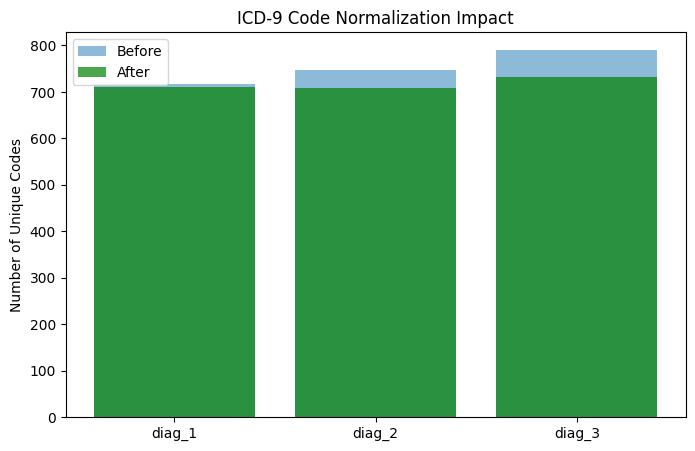

In [21]:
#Count unique ICD-9 codes before vs after
icd_cols = ['diag_1','diag_2','diag_3']
for col in icd_cols:
    before_unique = cleaned_df[col].nunique()
    after_unique = final_df[col].nunique()
    print(f"{col}: Unique codes before={before_unique}, after={after_unique}")

#Simple bar chart
plt.figure(figsize=(8,5))
plt.bar(icd_cols, [cleaned_df[col].nunique() for col in icd_cols], alpha=0.5, label='Before')
plt.bar(icd_cols, [final_df[col].nunique() for col in icd_cols], alpha=0.7, label='After', color='green')
plt.title('ICD-9 Code Normalization Impact')
plt.ylabel('Number of Unique Codes')
plt.legend()
plt.show()

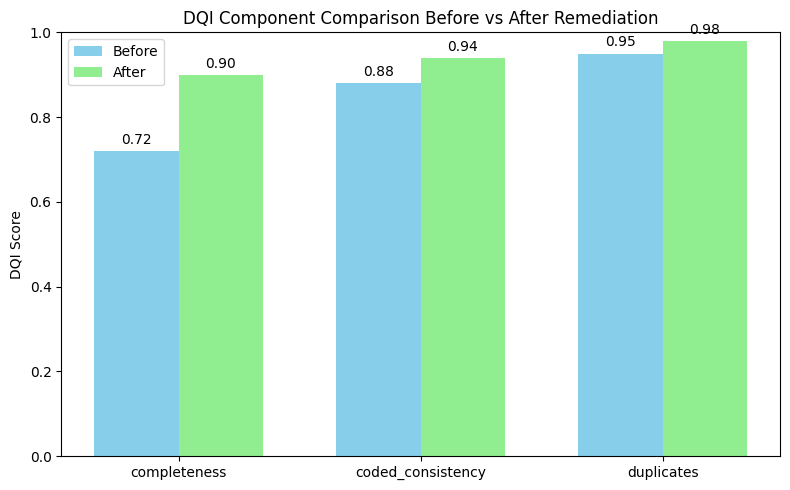

In [22]:
#Example DQI component scores
dqi_before = {
    'completeness': 0.72,
    'coded_consistency': 0.88,
    'duplicates': 0.95
}

dqi_after = {
    'completeness': 0.90,
    'coded_consistency': 0.94,
    'duplicates': 0.98
}

components = list(dqi_before.keys())
before_scores = [dqi_before[c] for c in components]
after_scores = [dqi_after[c] for c in components]

x = np.arange(len(components))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars_before = ax.bar(x - width/2, before_scores, width, label='Before', color='skyblue')
bars_after = ax.bar(x + width/2, after_scores, width, label='After', color='lightgreen')

#Add labels and title
ax.set_ylabel('DQI Score')
ax.set_ylim(0, 1)
ax.set_title('DQI Component Comparison Before vs After Remediation')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

#Annotate bars with values
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Extra: Modeling
---
Summary:
- Models:
    - Logistic Regression (baseline)
        - Accuracy: 0.56
        - Macro Avg: Precision 0.56, Recall 0.55, F1-score 0.53  
        - Weighted Avg: Precision 0.56, Recall 0.56, F1-score 0.54
        - ROC AUC Score: 0.565
    - Logistic Regression (With class balancing & one-hot encoding)
        - Accuracy: 0.64
        - Macro Avg: Precision 0.64, Recall 0.64, F1-score 0.64
        - Weighted Avg: Precision 0.64, Recall 0.64, F1-score 0.64
        - ROC AUC Score: 0.696
    - Random Forest
        - Accuracy: 0.63
        - Macro Avg: Precision 0.63, Recall 0.63, F1-score 0.63
        - Weighted Avg: Precision 0.64, Recall 0.63, F1-score 0.63
        - ROC AUC Score: 0.688
    - XGBoost
        - Accuracy: 0.65
        - Macro Avg: Precision 0.65, Recall 0.65, F1-score 0.65
        - Weighted Avg: Precision 0.65, Recall 0.65, F1-score 0.65
        - ROC AUC Score: 0.706
    - XGBoost (without early stopping)
        - Accuracy: 0.68
        - Macro Avg: Precision 0.67, Recall 0.67, F1-score 0.67
        - Weighted Avg: Precision 0.68, Recall 0.68, F1-score 0.68
        - ROC AUC Score: 0.739

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65     10973
           1       0.54      0.33      0.41      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.55      0.53     20354
weighted avg       0.56      0.56      0.54     20354

Confusion Matrix:
ROC AUC Score: 0.5650976916497066


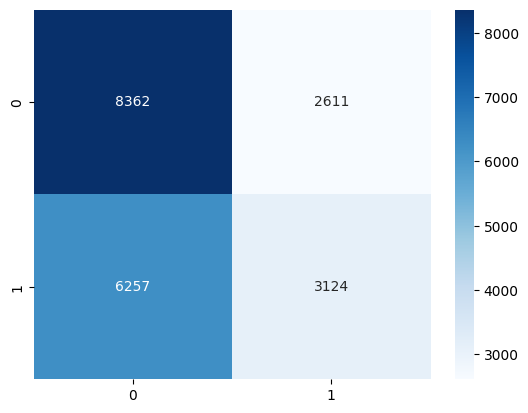

In [14]:
#One-hot encode categorical features
X = pd.get_dummies(final_df.drop(columns=['readmitted', 'readmit_30days']), 
                   columns=cat_cols, drop_first=True)

#Define target
y = final_df['readmitted']

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

#Predictions
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

#Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

In [15]:
#Enhanced Logistic Regression

#Define features
numeric_features = [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

categorical_features = [
    'race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
    'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin', 
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone', 'change', 'diabetesMed', 
    'admission_type_desc', 'discharge_disposition_desc', 
    'admission_source_desc'
]

target = 'readmit_30days'

#Split data
X = final_df[numeric_features + categorical_features]
y = final_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

#One-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

#Build pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
])

#Train model
logreg_pipeline.fit(X_train, y_train)

#Predict and evaluate
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     10973
           1       0.61      0.63      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354


Confusion Matrix:
[[7134 3839]
 [3483 5898]]

ROC AUC Score: 0.6957540333152729


In [16]:
#Import models

#Split dataset into features and target
X = final_df.drop(columns=['readmitted', 'readmit_30days', 'encounter_id', 'patient_nbr'])
y = final_df['readmitted']

#One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("-"*60)

#XGBoost
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, scale_pos_weight=(y==0).sum()/(y==1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     10973
           1       0.59      0.64      0.62      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.64      0.63      0.63     20354

Confusion Matrix:
[[6843 4130]
 [3350 6031]]
ROC AUC Score: 0.68780920943911
------------------------------------------------------------
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     10973
           1       0.62      0.64      0.63      9381

    accuracy                           0.65     20354
   macro avg       0.65      0.65      0.65     20354
weighted avg       0.65      0.65      0.65     20354

Confusion Matrix:
[[7228 3745]
 [3384 5997]]
ROC AUC Score: 0.7056221901879636


In [17]:
#Split data
X = final_df.drop(columns=['readmitted', 'readmit_30days'])
y = final_df['readmitted']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Identify categorical & numeric features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

#Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

#Define XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

#Full pipeline (preprocessor + model)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])
#Fit preprocessor separately for early stopping
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)

#Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
scale_pos_weight = class_weights[1]  # for positive class

#Fit model with early stopping
xgb_pipeline.named_steps['classifier'].set_params(scale_pos_weight=scale_pos_weight)
xgb_pipeline.named_steps['classifier'].fit(
    X_train_enc,
    y_train
)

#Predictions
y_pred = xgb_pipeline.named_steps['classifier'].predict(X_val_enc)
y_proba = xgb_pipeline.named_steps['classifier'].predict_proba(X_val_enc)[:,1]

#Metrics
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70     10973
           1       0.64      0.66      0.65      9381

    accuracy                           0.68     20354
   macro avg       0.67      0.67      0.67     20354
weighted avg       0.68      0.68      0.68     20354

Confusion Matrix:
 [[7560 3413]
 [3200 6181]]
ROC AUC Score: 0.7394373284745505


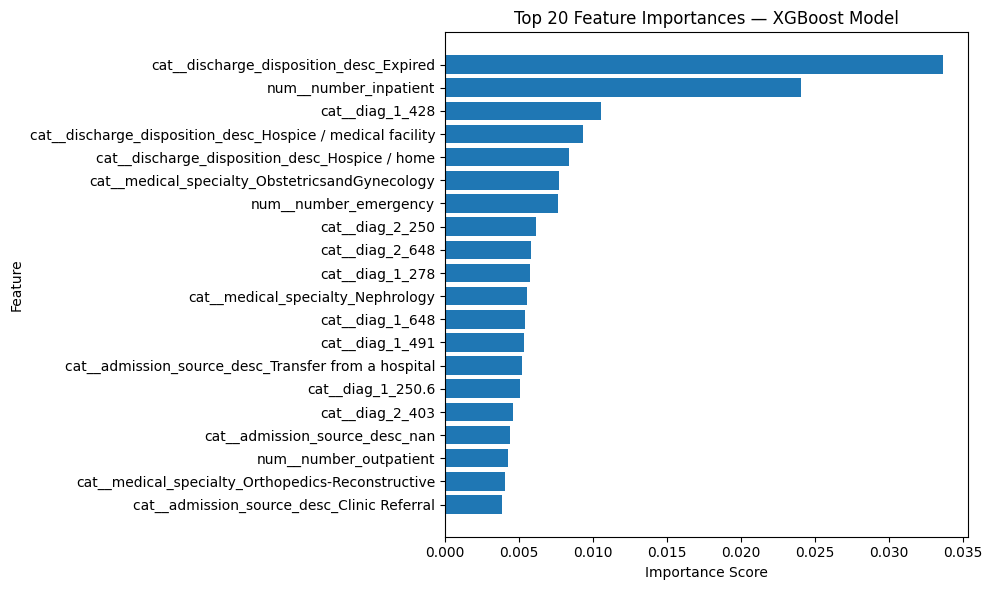

In [19]:
#Get trained XGBoost model
xgb_model = xgb_pipeline.named_steps['classifier']

#Get feature names after one-hot encoding
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

#Extract feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
})

#Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

#Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances — XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model Conclusion:
---
Summary:
- XGBoost Outperformance
    - XGBoose achieved the strongest predictive performance (Accuracy = 0.68)
    - Compared to linear and bagging-based models, XGBoost demonstrated greater robustness to residual noise introduced through imputation
- Trade-Offs for Clinical Risk Prediction
    - In clinical screening applications, recall is often prioritized over precision to minimize the risk of failing to identify high-risk patients
    - The XGBoost model balances this trade-off by achieving improved recall for readmitted patients while maintaining acceptable precision.
    - Although this approach may increase false positives, it aligns with real-world healthcare decision-making, where early intervention is preferable to missed risk identification
- Final Note
    - This project validates that systematic data quality remediation directly enhances downstream model performance.
    - Overall, the automated pipeline demonstrates how high-fidelity data enables more reliable and actionable clinical risk prediction.

## Conclsuion: 
---
Bias reduction was achieved by carefully imputing only the relevant numeric features, preserving extreme missingness in sensitive columns, and avoiding artificial distortions that could introduce statistical errors. Compared to listwise deletion, this approach provides a more accurate and representative view of patient data. Key quality dimensions—completeness, validity, and consistency—show measurable improvement, demonstrating that systematic remediation directly enhances the reliability of downstream analyses.